###**Start**

In [4]:
!pip install omegaconf dacite xlstm

In [5]:
# restart notebook

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from omegaconf import OmegaConf
from pprint import pprint
from dacite import from_dict
from dacite import Config as DaciteConfig
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

In [8]:
from xlstm.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig

In [9]:
device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
device_

device(type='cuda')

In [11]:
# display options
pd.set_option('display.max_columns', None)

In [12]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
# read data
df = pd.read_csv("/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/ETTh1.csv")

In [14]:
df.shape

(17420, 8)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17420 non-null  object 
 1   HUFL    17420 non-null  float64
 2   HULL    17420 non-null  float64
 3   MUFL    17420 non-null  float64
 4   MULL    17420 non-null  float64
 5   LUFL    17420 non-null  float64
 6   LULL    17420 non-null  float64
 7   OT      17420 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


In [16]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
df.set_index('date', inplace=True)

In [18]:
df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


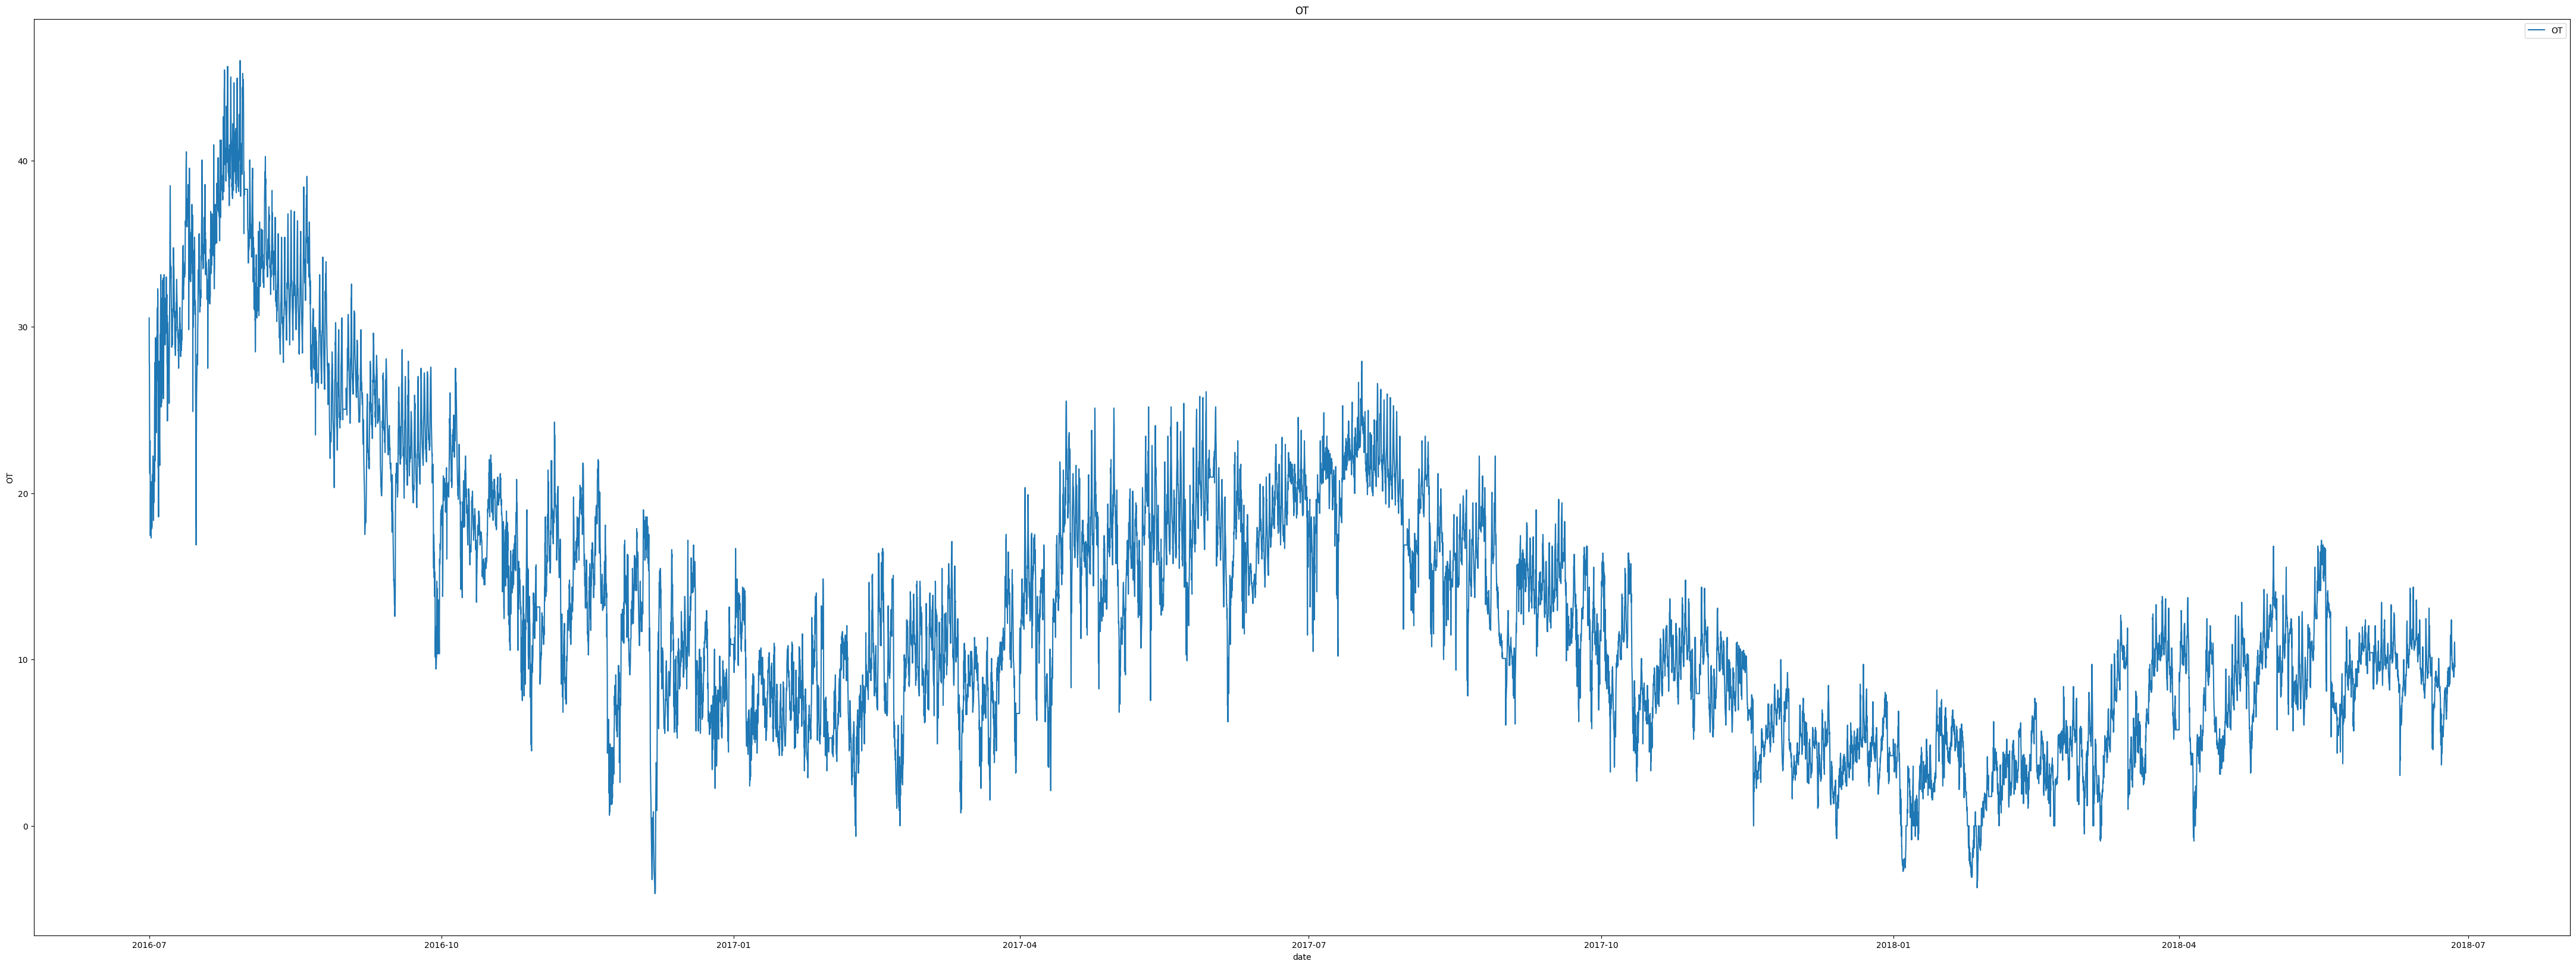

In [19]:
plt.figure(figsize=(55, 20))
sns.lineplot(data=df, x=df.index, y="OT", label="OT")
plt.xlabel('date')
plt.ylabel('OT')
plt.title('OT')
plt.autoscale(enable=True)
plt.legend()
plt.show()

In [20]:
scaler = MinMaxScaler(feature_range=(0,1))

In [21]:
data = df.values

In [22]:
len(data)*0.7

12194.0

In [23]:
len_df = len(data)
df_train = data[:int(len_df*0.7)]
df_valid = data[int(len_df*0.7):int(len_df*0.9)]
df_test = data[int(len_df*0.9):len_df]

In [24]:
df_train.shape

(12194, 7)

In [25]:
df_valid.shape

(3484, 7)

In [26]:
df_test.shape

(1742, 7)

In [27]:
train_scaled = scaler.fit_transform(df_train)
val_scaled = scaler.transform(df_valid)
test_scaled = scaler.transform(df_test)

In [28]:
# import pickle

# with open('min_max_scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [29]:
train_scaled.shape

(12194, 7)

In [30]:
val_scaled.shape

(3484, 7)

In [31]:
test_scaled.shape

(1742, 7)

In [32]:
window_size=24
output_size=1
target_column_index=6
batch_size=64

In [33]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_index, window_size):
        self.data = data
        self.target_index = target_index
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size, self.target_index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


train_dataset = TimeSeriesDataset(train_scaled, target_column_index, window_size)
val_dataset = TimeSeriesDataset(val_scaled, target_column_index, window_size)
test_dataset = TimeSeriesDataset(test_scaled, target_column_index, window_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 24, 7])
Labels batch shape: torch.Size([64])


###**xLSTM**

In [74]:
xlstm_cfg = f"""
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
    num_heads: 1
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 24
num_blocks: 5
embedding_dim: 7
dropout: 0.2
slstm_at: [] #[1] # for [] it also works, so if no sLSTM is in the stack
"""

In [75]:
cfg = OmegaConf.create(xlstm_cfg)
cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))
# pprint(cfg)

In [76]:
class xlstm(torch.nn.Module):
    def __init__(self, features, config):

        super(xlstm, self).__init__()

        self.features = features

        self.xlstm_stack = xLSTMBlockStack(config)

        self.mm= nn.Linear(self.features, 1)

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.xlstm_stack(x)

        x=self.mm(x[:,-1,:])

        x = self.sigmoid(x)

        return x

In [77]:
n_features = train_features.size()[-1]
xlstm_model =  xlstm(n_features, cfg)

In [78]:
xlstm_model

xlstm(
  (xlstm_stack): xLSTMBlockStack(
    (blocks): ModuleList(
      (0-4): 5 x mLSTMBlock(
        (xlstm_norm): LayerNorm()
        (xlstm): mLSTMLayer(
          (proj_up): Linear(in_features=7, out_features=128, bias=False)
          (q_proj): LinearHeadwiseExpand(in_features=64, num_heads=16, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (k_proj): LinearHeadwiseExpand(in_features=64, num_heads=16, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (v_proj): LinearHeadwiseExpand(in_features=64, num_heads=16, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (conv1d): CausalConv1d(
            (conv): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
          )
          (conv_act_fn): SiLU()
          (mlstm_cell): mLSTMCell(
            (igate): Linear(in_features=192, out_features=4, bias=True)
            (fgate): Linear(in_features=192, 

In [79]:
xlstm_model = xlstm_model.to(device_)

In [80]:
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(xlstm_model.parameters(), lr=1e-4)

In [81]:
train_loss_list = []
val_loss_list = []

In [82]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [83]:
def validate_xlstm(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for itr in val_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    return val_loss / len(val_loader)

In [84]:
def train_xlstm(model, train_loader, val_loader, num_epochs, patience, criterion, device):
    train_loss_list.clear()
    val_loss_list.clear()

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for itr in train_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            # print(targets)
            # print(outputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            # print(loss.item())

        train_loss_for_epoch = train_loss/len(train_loader)
        val_loss_for_epoch = validate_xlstm(model, val_loader, criterion_mse, device)

        train_loss_list.append(round(train_loss_for_epoch, 4))
        val_loss_list.append(round(val_loss_for_epoch, 4))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_for_epoch:.4f}, Val Loss: {val_loss_for_epoch:.4f}')

        early_stopping(val_loss_for_epoch)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [85]:
train_xlstm(xlstm_model, train_loader, val_loader, 50, 5, criterion_mse, device_)

Epoch 1/50, Train Loss: 0.0475, Val Loss: 0.0588
Epoch 2/50, Train Loss: 0.0294, Val Loss: 0.0347
Epoch 3/50, Train Loss: 0.0220, Val Loss: 0.0298
Epoch 4/50, Train Loss: 0.0184, Val Loss: 0.0279
Epoch 5/50, Train Loss: 0.0154, Val Loss: 0.0264
Epoch 6/50, Train Loss: 0.0136, Val Loss: 0.0257
Epoch 7/50, Train Loss: 0.0119, Val Loss: 0.0246
Epoch 8/50, Train Loss: 0.0110, Val Loss: 0.0238
Epoch 9/50, Train Loss: 0.0101, Val Loss: 0.0229
Epoch 10/50, Train Loss: 0.0097, Val Loss: 0.0221
Epoch 11/50, Train Loss: 0.0089, Val Loss: 0.0216
Epoch 12/50, Train Loss: 0.0087, Val Loss: 0.0206
Epoch 13/50, Train Loss: 0.0081, Val Loss: 0.0197
Epoch 14/50, Train Loss: 0.0079, Val Loss: 0.0189
Epoch 15/50, Train Loss: 0.0075, Val Loss: 0.0185
Epoch 16/50, Train Loss: 0.0074, Val Loss: 0.0175
Epoch 17/50, Train Loss: 0.0070, Val Loss: 0.0167
Epoch 18/50, Train Loss: 0.0068, Val Loss: 0.0161
Epoch 19/50, Train Loss: 0.0065, Val Loss: 0.0157
Epoch 20/50, Train Loss: 0.0065, Val Loss: 0.0147
Epoch 21/

In [86]:
def plot_learning_curves(train_loss, val_loss):
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss, "b-", label="Training loss")
    plt.plot(np.arange(1, len(val_loss) + 1), val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")

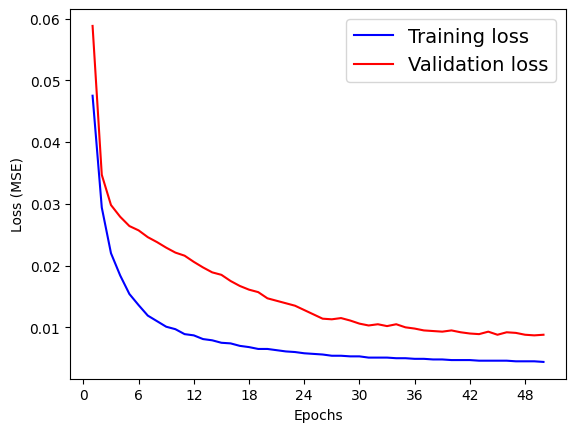

In [87]:
plot_learning_curves(train_loss_list, val_loss_list)
plt.show()

In [88]:
torch.save(xlstm_model.state_dict(), "/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/ETTh1_xLSTM__mmmmm.pth")

In [89]:
# loading a model
# loaded_model =  xlstm(n_features, cfg)
# model_path = '/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/ETTh1_xLSTM__mss.pth'
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model = loaded_model.to(device_)

In [90]:
actual_list = []
pred_list = []

In [91]:
def test_model(model, test_loader, criterion, device):
    actual_list.clear()
    pred_list.clear()

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for itr in test_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            out = outputs.squeeze()

            for outs in out:
              pred_list.append(outs.item())
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

In [92]:
test_model(xlstm_model, test_loader, criterion_mse, device_)

Test Loss: 0.0037


In [93]:
test_model(xlstm_model, test_loader, criterion_mae, device_)

Test Loss: 0.0449


In [94]:
mx = scaler.data_max_[target_column_index]
mn = scaler.data_min_[target_column_index]
rng= scaler.data_range_[target_column_index]

In [95]:
len(pred_list)

1718

In [96]:
df_test.shape

(1742, 7)

In [97]:
print(mx, mn, rng)

46.00699996948242 -4.079999923706056 50.08699989318848


In [98]:
df_test

array([[15.8739996 ,  1.94200003, 10.8739996 , ...,  4.78200006,
         0.82200003,  5.13500023],
       [13.12800026,  1.875     ,  7.88899994, ...,  5.05600023,
         1.523     ,  5.76800013],
       [ 3.148     ,  1.54100001, -2.34500003, ...,  5.23899984,
         1.49199998,  4.85400009],
       ...,
       [ 2.81299996,  3.81800008, -0.81699997, ...,  3.71600008,
         1.523     , 10.27099991],
       [ 9.24300003,  3.81800008,  5.47200012, ...,  3.65499997,
         1.43200004,  9.77799988],
       [10.11400032,  3.54999995,  6.18300009, ...,  3.71600008,
         1.46200001,  9.56700039]])

In [99]:
X_test = df_test[window_size:, target_column_index]
actual = pd.DataFrame(X_test, columns=['actual'])

In [100]:
actual.isnull().sum()

,0
actual,0


In [101]:
actual['predictions'] = pred_list
actual['predictions'] = actual['predictions']*rng+mn
actual['signed_difference'] = (actual['predictions'] - actual['actual'])
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

In [102]:
actual.shape

(1718, 5)

In [103]:
len_df-int(len_df*0.9)

1742

In [104]:
test_df = df[-actual.shape[0]:]
test_df.shape

(1718, 7)

In [105]:
test_df.shape

(1718, 7)

In [106]:
test_df['index'] = test_df.index

In [107]:
res_X_test = actual[["actual", "predictions","signed_difference","difference","difference_percentage"]]

In [108]:
test_df = test_df.reset_index(drop=True)
res_X_test = res_X_test.reset_index(drop=True)
df_All_final = pd.concat([test_df['index'], res_X_test[["actual", "predictions","signed_difference","difference","difference_percentage"]]], axis=1)

In [109]:
df_All_final["difference_sq"] = df_All_final["difference"] ** 2

In [110]:
df_All_final

,index,actual,predictions,signed_difference,difference,difference_percentage,difference_sq
0,2018-04-16 06:00:00,6.191,8.982833,2.791833,2.791833,45.095028,7.794332
1,2018-04-16 07:00:00,6.331,9.072128,2.741129,2.741129,43.296931,7.513786
2,2018-04-16 08:00:00,6.542,9.106806,2.564806,2.564806,39.205226,6.578229
3,2018-04-16 09:00:00,6.683,7.840370,1.157370,1.157370,17.318126,1.339506
4,2018-04-16 10:00:00,6.964,9.342745,2.378744,2.378744,34.157731,5.658425
...,...,...,...,...,...,...,...
1713,2018-06-26 15:00:00,10.904,12.259735,1.355735,1.355735,12.433372,1.838017
1714,2018-06-26 16:00:00,11.044,10.280021,-0.763979,0.763979,6.917590,0.583663
1715,2018-06-26 17:00:00,10.271,11.478781,1.207781,1.207781,11.759141,1.458736
1716,2018-06-26 18:00:00,9.778,10.902517,1.124517,1.124517,11.500477,1.264538


In [111]:
# results
print("Error, less than or equal to 5%: ", round((df_All_final['difference_percentage'] <= 5).sum()/df_All_final.shape[0]*100, 2), "%")
print("Error, less than or equal to 10%: ", round((df_All_final['difference_percentage'] <= 10).sum()/df_All_final.shape[0]*100, 2), "%")
print("MSE: ", round(df_All_final['difference_sq'].mean(), 2))
print("RMSE: ", round(math.sqrt(df_All_final['difference_sq'].mean()), 2))
print("MAE: ", round(df_All_final['difference'].mean(), 2))
print("Max error: ", round(df_All_final['difference'].max(), 2))

Error, less than or equal to 5%:  15.95 %
Error, less than or equal to 10%:  32.65 %
MSE:  7.28
RMSE:  2.7
MAE:  1.94
Max error:  22.08


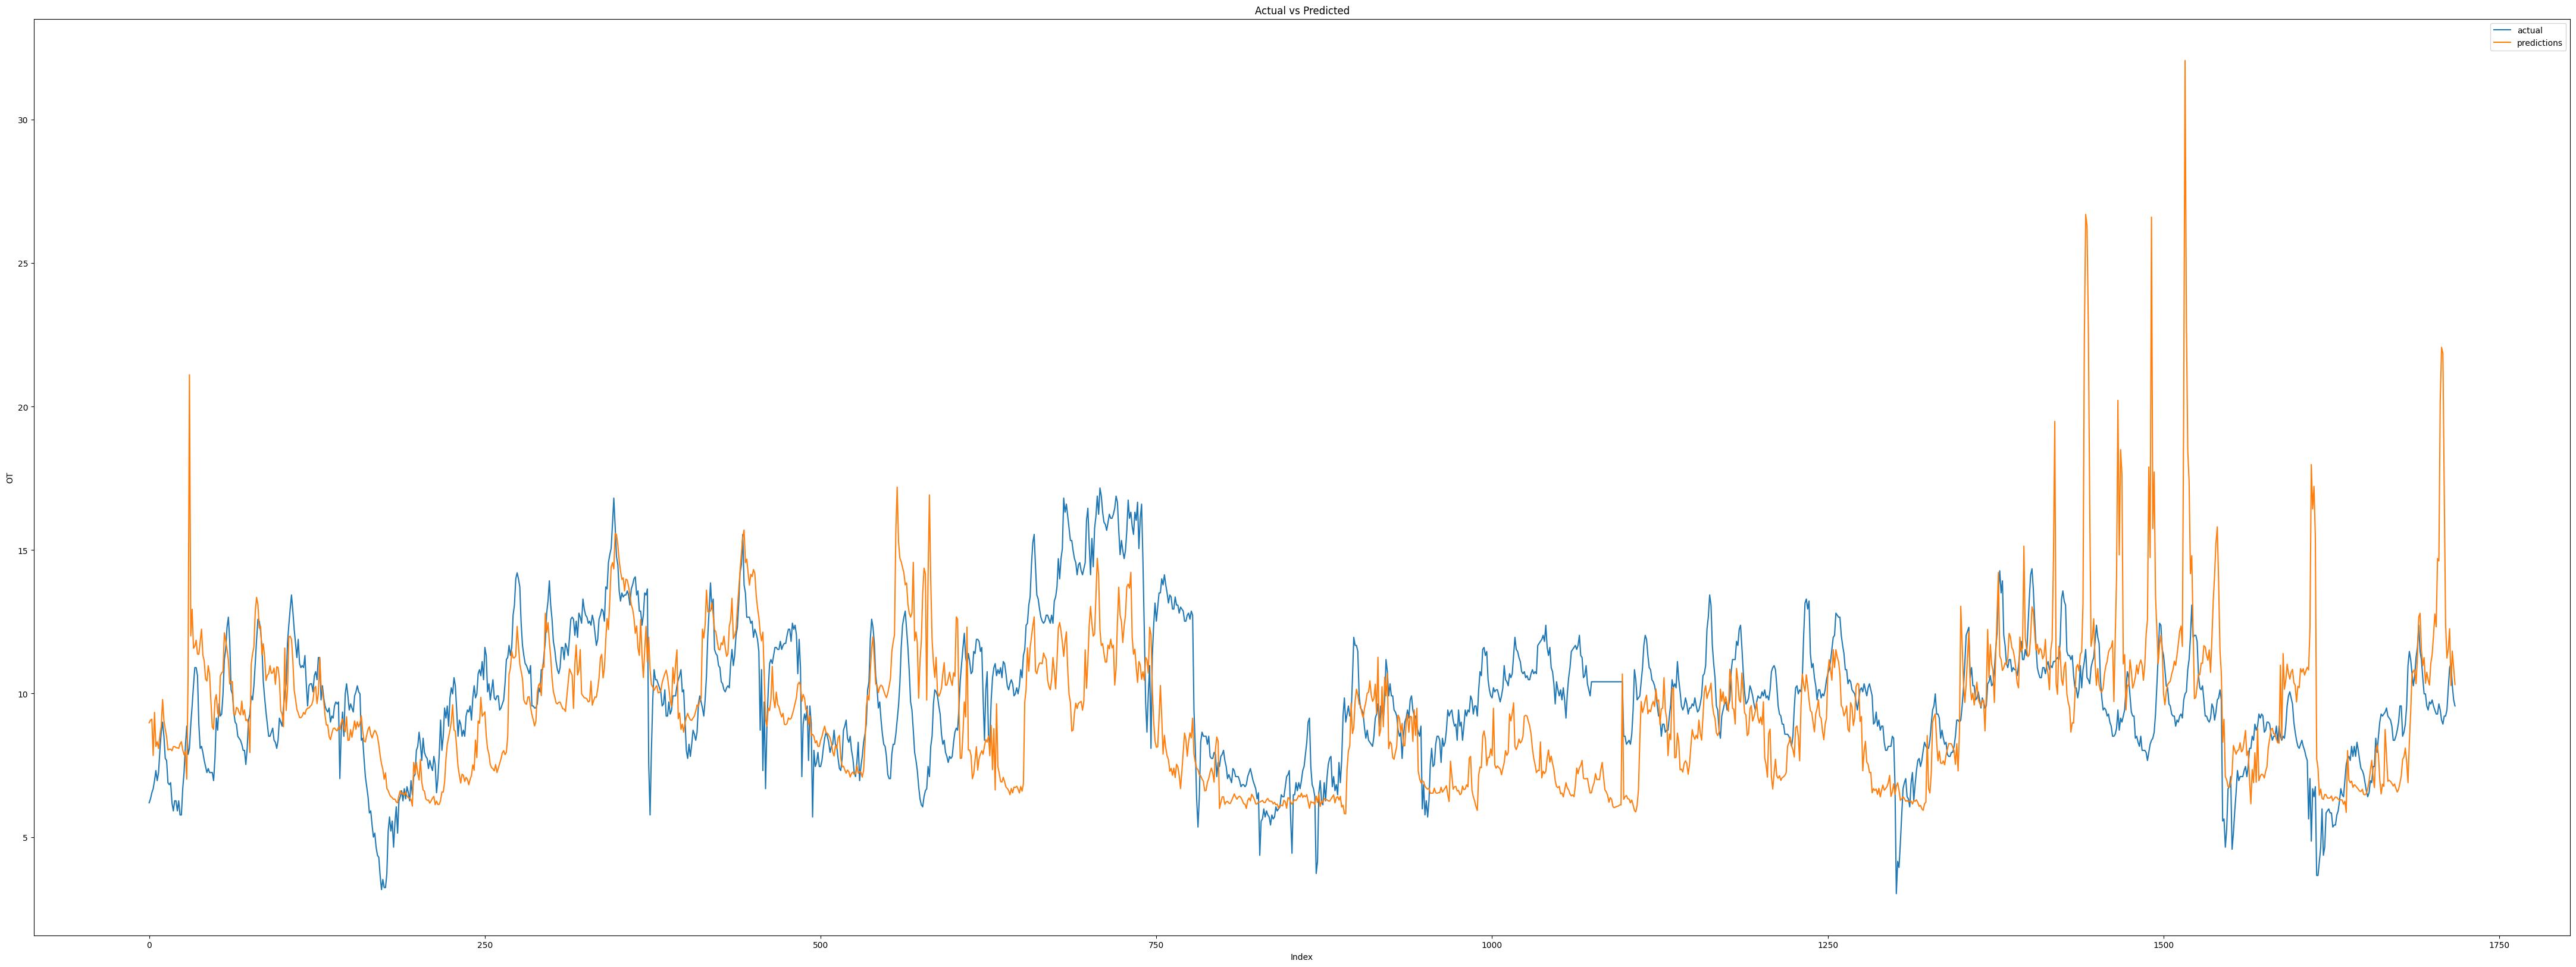

In [112]:
plt.figure(figsize=(55, 20))
sns.lineplot(data=df_All_final, x=df_All_final.index, y="actual", label="actual")
sns.lineplot(data=df_All_final, x=df_All_final.index, y="predictions", label="predictions")
plt.xlabel('Index')
plt.ylabel('OT')
plt.title('Actual vs Predicted')
plt.autoscale(enable=True)
plt.legend()
plt.show()